---
1. Demuestre la siguiente identidad de acuerdo a las definiciones vistas en la clase 1, demuestre.

$$
rms(x)^2 = avg(x)^2 + stf(x)^2
$$

Sea x $\in \mathbb{R}^n$. \
Como:

$$rms(x) = \sqrt(\frac{x^2_1 + ... + x^2_n}{n}) = \frac{||x||}{\sqrt(n)}$$

$$std(x) = rms(x - avg(x)\textbf{1}) = \frac{1}{\sqrt(n)}\sqrt(\sum\limits_{i=1}^n(x_i - avg(x))^2)$$



Entonces:

$$
rms(x)^2 = avg(x)^2 + stf(x)^2
$$

$$
rms(x)^2 = avg(x)^2 + \frac{1}{n}\sum\limits_{i=1}^n(x_i - avg(x))^2
$$

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n(
    x_i^2 - 2avg(x)x_i + avg(x)^2
)
$$

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 

- \frac{1}{n}\sum\limits_{i=1}^n 2 avg(x) x_i 

+ \frac{1}{n}\sum\limits_{i=1}^n avg(x)^2
$$

Como avg(x) es una constante, entonces:

$$
rms(x)^2 = avg(x)^2 + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 

- \frac{2avg(x)}{n}\sum\limits_{i=1}^n  x_i 

+ \frac{avg(x)^2 \cancel{n}}{\cancel{n}} 
$$

Luego, como:

$$avg(x) = \frac{1}{n} \sum\limits_{i=1}^nx_i$$

Entonces:

$$
rms(x)^2 = \cancel{avg(x)^2} + 
\frac{1}{n}\sum\limits_{i=1}^n x_i^2 
- \cancel{2avg(x)^2} + \cancel{avg(x)^2} 
$$

$$
rms(x)^2 = \frac{1}{n}\sum\limits_{i=1}^n x_i^2 
$$

$$rms(x) = \sqrt(\frac{1}{n}\sum\limits_{i=1}^n x_i^2) \space \space \square$$


---

---
2. Este problema trataremos el problema de clustering, es decir, determinar los k representates de un conjunto de datos y las etiquetas de estos que minimizan la distancia de cada cluster a su representante.

    - a) Programe el algortimo de k-means. Construya una rutina 
        $$k\_means\_fit(X, Z0, NITERMAX)$$
        donde X son los datos Z0 son los representates iniciales, y NITERMAX es el número máximo de iteraciones.

    - b) Use la base de datos datakmeans.csv para testear su algoritmo con k = 5 representantes. Grafique el conjunto de datos X por etiqueta y los representates de cada cluster. Grafique el comportamientov de la función respecto al número de iteraciones y discuta el número de iteraciones adecuado para el clustering.

    - c) Use la base de datos de imágenes de dígitos de MNIST para testear su algoritmo con k = 20 representantes. Grafique cada representante y uno de los datos asignados a dicho cluster. Grafique el comportamiento de la función objetivo Jclust versus al número de iteraciones y discuta el numero de iteraciones adecuado para el clustering.

    - d) Discuta porque el algoritmo de k − means converge, es decir, es seguro que de una iteración a la siguiente la función objetivo decrece?

In [2]:
import numpy as np
import pandas as pd
import random
from typing import List, Tuple, Callable, Literal, Union
import matplotlib.pyplot as plt

In [3]:
class KMeans:
    def __init__(
        self, k = 2, max_iters = 100, 
        distance : Literal['euclidiana'] = 'euclidiana',
        cs_politic : Literal['mean'] = 'mean',
        init: Union[Literal['random'], Literal['k_means_plus']] = 'random'
    ):
        self.k = k
        self.max_iters = max_iters
        
        self.distance = getattr(self, f'{distance}_distance')
        self.cs_politic = getattr(self, f'{cs_politic}_selector')
        self.init = getattr(self, f'{init}_init')

        self.memory = []
        self.data = None
        self.inertia = []

    def fit(self, X):
        self.data = X

        # Select k random points as initial centroids
        centroids = self.init(X)
        
        # Loop until convergence or max iterations reached
        for i in range(self.max_iters):

            clusters = [[] for _ in range(self.k)]
            
            # Assign samples to clusters
            for idx, sample in enumerate(X):
                distances = [self.distance(sample, centroid) for centroid in centroids]
                min_dist_idx = np.argmin(distances)
                clusters[min_dist_idx].append(idx)

            # Stop criteria cluster equally        
            if (i > 0 and 
                all(set(pc) == set(nc) 
                    for pc, nc in zip(self.memory[-1][1], clusters)
                )
            ):
                break

            # Update centroids to be the mean of the points assigned to them
            self.memory.append((centroids, clusters))
            self.inertia.append(self.j_cluster(centroids, clusters))

            print('Iteration {0:n} {1:.3f}'.format(i + 1, self.inertia[-1]))
            new_centroids = self.cs_politic(X, clusters)

            # Stop criteria centroids equally
            if np.allclose(centroids, new_centroids):
                break

            centroids = new_centroids

        self.centroids = centroids
        return self.labels_by_clusters(X, clusters)

    def labels_by_clusters(self, X, clusters):
        labels = np.zeros(X.shape[0])
        for i, cluster in enumerate(clusters):
            labels[cluster] = i
        return labels
    
    def j_cluster(self, centroids, clusters):
        j_cluster = 0
        for c, cluster in zip(centroids, clusters):
            j_cluster += sum([np.sum((self.data[v] - c) ** 2) for v in cluster])
        return j_cluster / len(self.data)

    #######################################
    #          Distances                  #
    #######################################

    def euclidiana_distance(self, X, Y):
        assert len(X) == len(Y)

        # definition
        # result = np.sqrt(np.sum([(x - y)*(x - y) for x, y in zip(X, Y)]))

        # numpy version 
        n_result = np.linalg.norm(X - Y)

        # They should be similar :)
        # if not np.allclose(n_result, result):
        #     print("Distance Warning")
        return n_result 
    
    #######################################
    #        Centroid Selection           #
    #######################################

    def mean_selector(self, X, clusters):
        return np.array([X[c].mean(axis=0) for c in clusters])
    
    #######################################
    #        Centroid Initial             #
    #######################################

    def random_init(self, X):
        return random.choices(X, k=self.k) 
    
    def k_means_plus_init(self, X):

        centroids = [random.randint(0, len(X) - 1)]
        for _ in range(self.k - 1):
            candidates = []
            for i, v in enumerate(X):
                if i in centroids: continue

                distances = [self.distance(X[c], v) for c in centroids]
                candidates.append((min(distances), i))

            _, new_centroid = max(candidates)
            centroids.append(new_centroid)

        return X[centroids]

In [4]:
df = pd.read_csv('./datakmeans.csv')
df.head()

,0,1
0,-4.272404,-9.667048
1,-1.848082,-4.687662
2,8.816753,0.101368
3,6.743281,-2.990887
4,-4.751872,-7.044639


In [5]:
model = KMeans(5)
numpy_data = df.to_numpy()
labels = model.fit(numpy_data)

Iteration 1 9.365
Iteration 2 5.895
Iteration 3 5.883
Iteration 4 5.882
Iteration 5 5.881
Iteration 6 5.880
Iteration 7 5.875
Iteration 8 5.871
Iteration 9 5.866
Iteration 10 5.864
Iteration 11 5.861
Iteration 12 5.860
Iteration 13 5.859
Iteration 14 5.857
Iteration 15 5.856
Iteration 16 5.855
Iteration 17 5.853
Iteration 18 5.849
Iteration 19 5.846
Iteration 20 5.844
Iteration 21 5.843


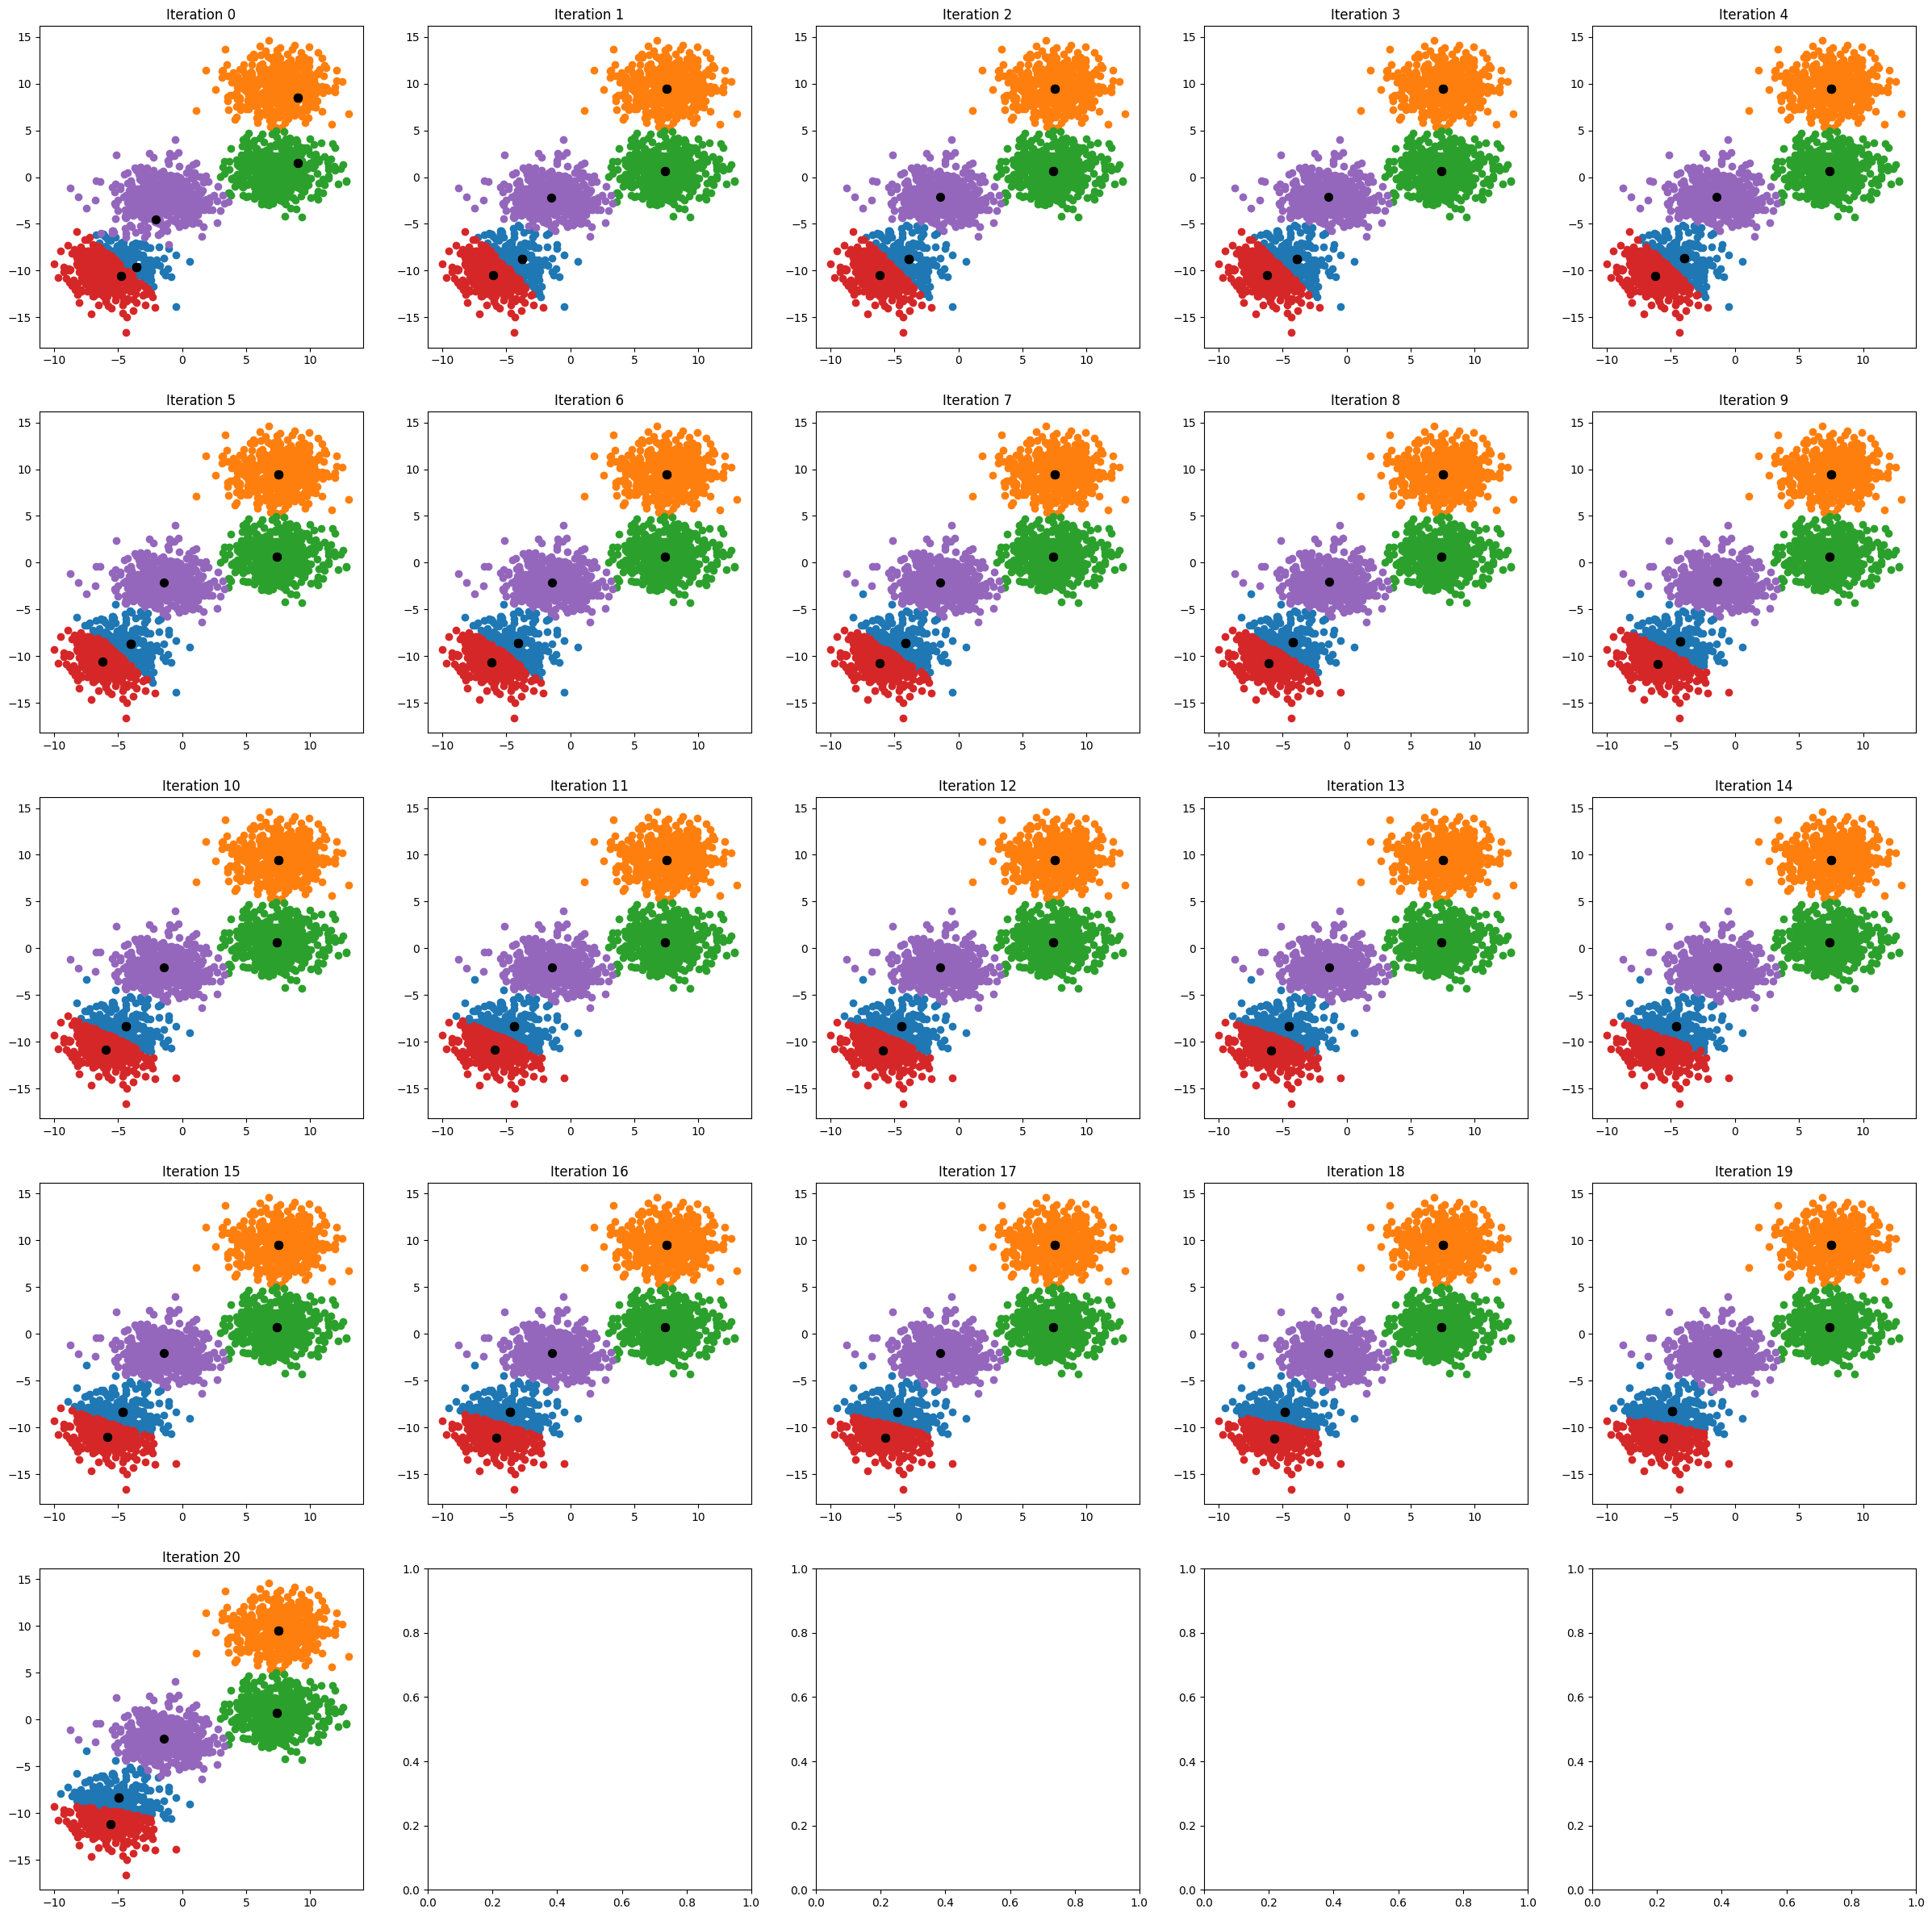

In [12]:
import math

def graphic_mosaic(model):

    rows = int(math.sqrt(len(model.memory)))
    fig, ax = plt.subplots(nrows=rows + 1, ncols=rows + 1,  figsize=(30,30))

    iter_cluster = enumerate(model.memory)
    for i in range(rows + 1):
        for j in range(rows + 1):
            try:
                index, (centroids, clusters) = next(iter_cluster)
            except StopIteration:
                break
            
            centroids = np.array(centroids)
            for col, cluster in enumerate(clusters):
                ax[i,j].scatter(
                    numpy_data[cluster,0], 
                    numpy_data[cluster,1], c=f'C0{col}'
                )
                ax[i,j].set_title(f'Iteration {index}')
                ax[i,j].scatter(centroids[:, 0], centroids[:, 1], s=50, c='black')

    plt.show()

graphic_mosaic(model)

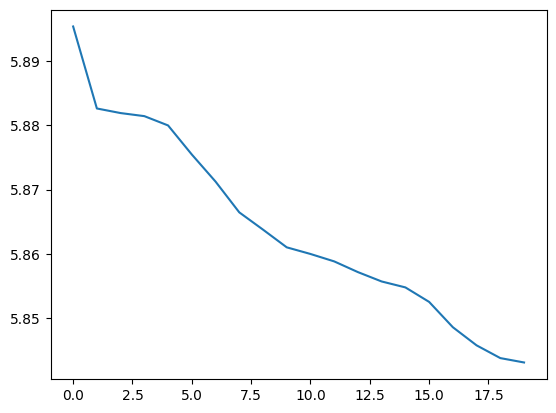

In [13]:
_ = plt.plot(range(len(model.inertia) - 1), model.inertia[1:])

Iteration 1 25.618
Iteration 2 7.838
Iteration 3 5.968
Iteration 4 5.820
Iteration 5 5.804
Iteration 6 5.798
Iteration 7 5.796
Iteration 8 5.795
Iteration 9 5.795
Iteration 10 5.794


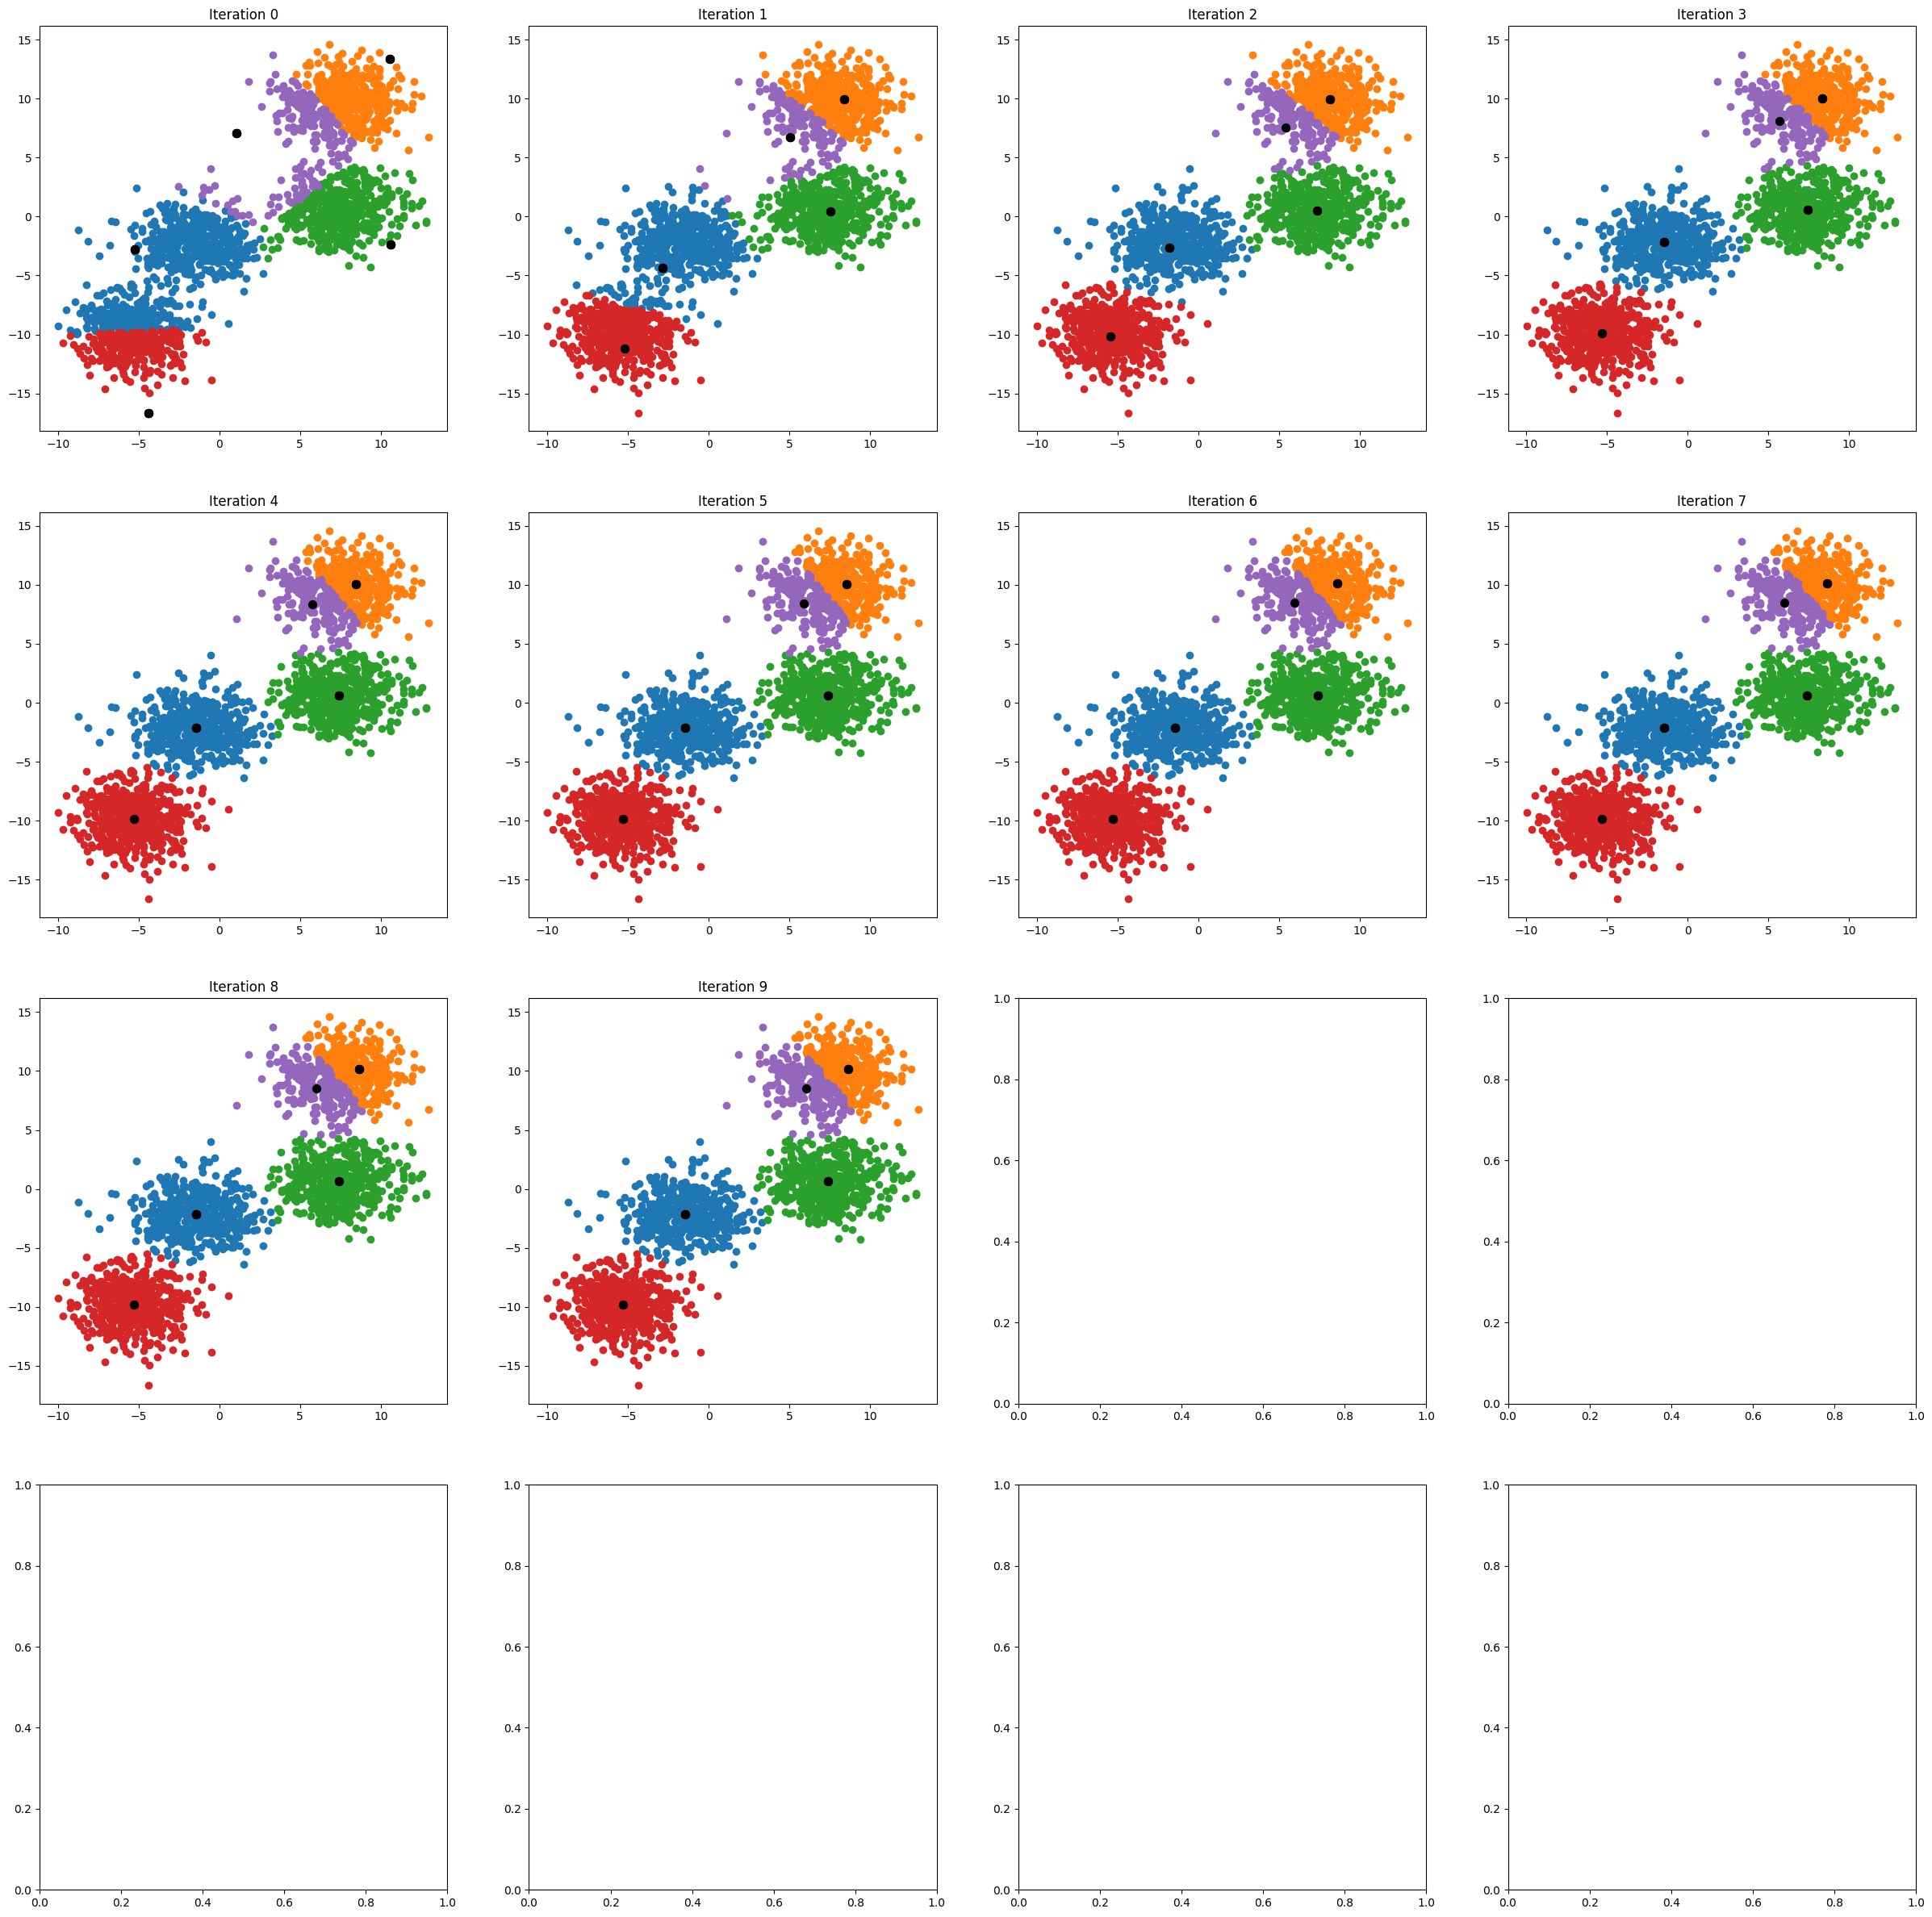

In [14]:
model = KMeans(5, init='k_means_plus')
labels = model.fit(numpy_data)

graphic_mosaic(model)

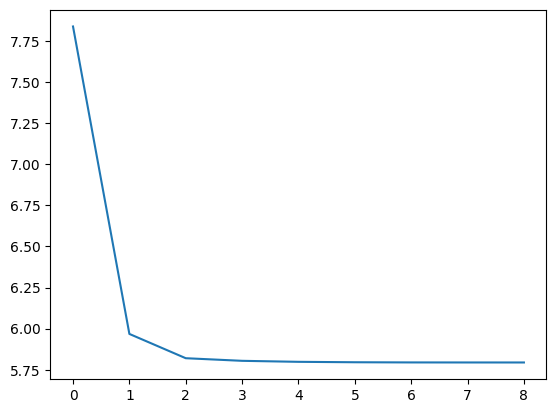

In [15]:
_ = plt.plot(range(len(model.inertia) - 1), model.inertia[1:])

In [16]:
import idx2numpy

file = './train-images.idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
arrnew = np.array([arr_j.flatten() for arr_j in arr])


kmeans = KMeans(k=20, max_iters=1000)
pred_y = kmeans.fit(arrnew)

Iteration 1 16023.717
Iteration 2 2529106.696
Iteration 3 2398012.926
Iteration 4 2361847.240
Iteration 5 2342891.239
Iteration 6 2330018.777
Iteration 7 2319822.155
Iteration 8 2312621.463
Iteration 9 2307512.098
Iteration 10 2303790.263
Iteration 11 2300939.567
Iteration 12 2298830.101
Iteration 13 2297326.482
Iteration 14 2296346.245
Iteration 15 2295601.652
Iteration 16 2294949.251
Iteration 17 2294351.334
Iteration 18 2293782.004
Iteration 19 2293240.930
Iteration 20 2292772.924
Iteration 21 2292429.151
Iteration 22 2292217.473
Iteration 23 2292082.154
Iteration 24 2291988.805
Iteration 25 2291904.174
Iteration 26 2291835.902
Iteration 27 2291792.480
Iteration 28 2291758.643
Iteration 29 2291736.470
Iteration 30 2291718.986
Iteration 31 2291700.058
Iteration 32 2291681.979
Iteration 33 2291665.521
Iteration 34 2291649.833
Iteration 35 2291632.104
Iteration 36 2291611.906
Iteration 37 2291595.617
Iteration 38 2291582.163
Iteration 39 2291573.260
Iteration 40 2291565.317
Iteration 4

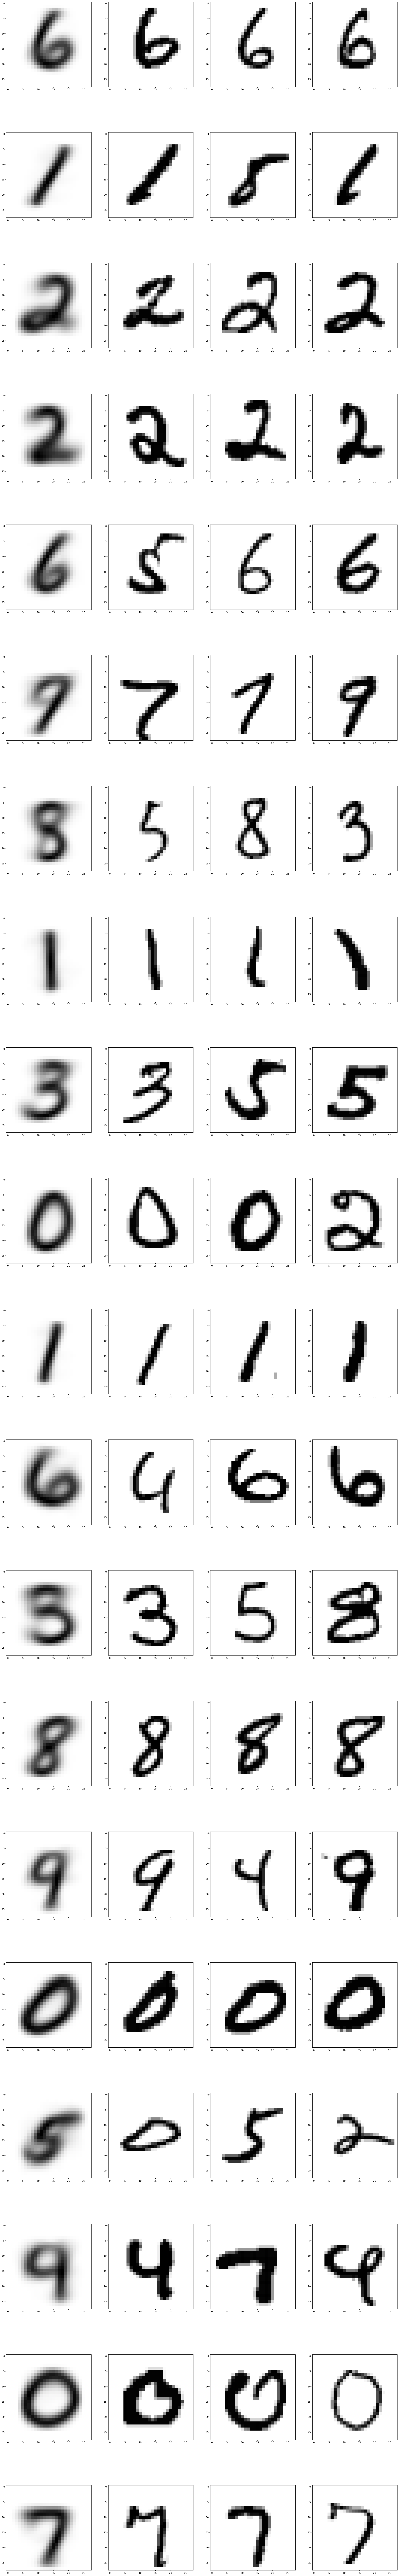

In [21]:
fig, ax = plt.subplots(nrows=20, ncols=4,  figsize=(30,200))
original_shape = arr[0].shape

for i, c in enumerate(kmeans.centroids):
    sample = random.choices(arr[pred_y == i], k=3)
    
    ax[i, 0].imshow(c.reshape(original_shape), cmap=plt.cm.binary)
    ax[i, 1].imshow(sample[0].reshape(original_shape), cmap=plt.cm.binary)
    ax[i, 2].imshow(sample[1].reshape(original_shape), cmap=plt.cm.binary)
    ax[i, 3].imshow(sample[2].reshape(original_shape), cmap=plt.cm.binary)


plt.show()

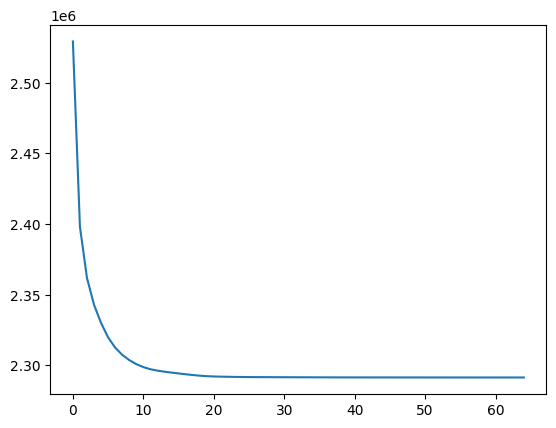

In [22]:
inertia_list = kmeans.inertia[1:]
_ = plt.plot(range(len(inertia_list)), inertia_list)

---
3. Considere una matriz de A $\in R^{m×n}$ con m > n y un vector b $\in R^m$. Buscamos el vector solución $x \in R^n$ del sistema lineal Ax = b. Describa como puede asegurar de forma práctica si la solución del sistema existe o no

`R\:` Podemos asegurar si existe una solución del sistema lineal Ax = b utilizando el teorema de rangos.

En primer lugar, podemos crear una matriz aumentada [A|b] que consiste en la matriz A combinada con el vector b como una columna adicional de la derecha.

Luego, podemos calcular el rango de la matriz A y también el rango de la matriz aumentada [A|b]. Si el rango de la matriz aumentada es mayor que el rango de la matriz A, entonces no hay solución única. Si el rango de ambas matrices es el mismo, entonces existe una solución única.

Si el rango de la matriz A es menor que el número de columnas, entonces existen infinitas soluciones. Podemos encontrar una solución particular utilizando cualquier método, como la eliminación gaussiana, y podemos encontrar el conjunto completo de soluciones a través de la ecuación homogénea Ax = 0.

En resumen, para asegurar si existe una solución única del sistema lineal Ax = b, podemos comparar el rango de la matriz A y la matriz aumentada [A|b]. Si el rango es igual, hay solución única y si el rango de la matriz aumentada [A|b] es mayor que el rango de la matriz A, entonces no existe solución única.

---

---
4. En este problema trataremos el problema de clasificación binaria, es decir, determinar si un dato pertenece a una de dos clases.

  - Programe el algoritmo del Perceptrón. Puede ser útil construir en este caso    una rutina 
    $$Perceptron\_fit(X, y, nitmax, eta)$$ 
    que tome los datos X, sus etiquetas y, y que retorne los pesos w delclasificador. Otros hiperparámetros a considerar son nitmax y eta quecorresponden respectivamente al número máximo de iteraciones del algoritmo y el learning rate.
  -  Programe una rutina que dado un vector de pesos w, y un conjunto de datos X prediga en a que conjunto de datos pertenece cada dato.
  - Programe una rutina que dado un vector de pesos w, un conjunto de datos X y sus etiquetas y, entregue un score de que tan bien clasificados están los datossegún las predicciones hechas por el clasificador.
  - Use las bases de datos datos1.csv y datos2.csv, grafique los datos identificando sus respectivas etiquetas y junto a ellos el resultado del hiperplano separador obtenido por su algoritmo de Perceptrón.
  - Cree 10 nuevos datos de la siguiente forma: 
  
    ```python    
    numpy.random.seed(18)
    new_data = numpy.random.random(size = (10, 2))
    new_data_labels = numpy.random.randint(2, size = 10)
    ```
    Para el primer set de datos, prediga la clase a la que pertenecen cada uno de sus datos con la función de predicción creada y calcule el score. Grafíque estos datos junto al conjunto inicial de datos y discuta la capacidad predictora de este clasificador.

In [60]:
import numpy as np

class Perceptron:
    def __init__(self, n_it_max, eta, w = None):
        self.eta = eta
        self.n_it_max = n_it_max

        if w:
            self.w = w[:-1]
            self.b = w[-1]
        
    def fit(self, X, y):
        (n, m) = X.shape
        
        # Initialize the weights
        self.w = np.random.randn(m)
        self.b = 0
        
        # The training loop
        for epoch in range(self.n_it_max):
            n_errors = 0
            
            for i in range(n):
                o = self.predict(X[i])
                if o != y[i]:
                    self.w += self.eta * (y[i] - o) * X[i]
                    self.b += self.eta * (y[i] - o)
                    n_errors += 1
            
            accuracy = 1 - (n_errors / n)
            print(f'Epoch {epoch + 1}: accuracy = {accuracy:.3f}')
            
            if n_errors == 0:
                break
    
    def _predict(self, x):
        z = x @ self.w + self.b
        return np.heaviside(z, 1)

    def predict(self, X):
        if len(X.shape) == 1:
            return self._predict(X)

        assert len(X.shape) == 2
        labels = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            labels[i] = self._predict(x)

        return labels
    
    def check_classification(self, Y, P):
        n_errors = 0
        
        for y, o in zip(Y, P):
            n_errors += o != y
        
        return 1 - (n_errors / len(Y))



In [61]:
def plot_hyperplane(X, Y, model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

    pos = X[Y == 1]
    ax.scatter(pos[:,0], pos[:,1], c='C00')

    neg = X[Y == 0]
    ax.scatter(neg[:,0], neg[:,1], c='C01')

    x = np.linspace(-3, 3, 5)
    y = - (model.w[0] * x + model.b) / model.w[1]

    plt.plot(x, y, c='C02')

    plt.show()

In [68]:
df = pd.read_csv('./data2.csv')

X = df[['x', 'y']].to_numpy()
Y = df['label'].to_numpy()

model = Perceptron(eta=0.01, n_it_max=100)
model.fit(X, Y)

Epoch 1: accuracy = 0.520
Epoch 2: accuracy = 0.510
Epoch 3: accuracy = 0.530
Epoch 4: accuracy = 0.580
Epoch 5: accuracy = 0.580
Epoch 6: accuracy = 0.540
Epoch 7: accuracy = 0.540
Epoch 8: accuracy = 0.550
Epoch 9: accuracy = 0.560
Epoch 10: accuracy = 0.550
Epoch 11: accuracy = 0.590
Epoch 12: accuracy = 0.560
Epoch 13: accuracy = 0.550
Epoch 14: accuracy = 0.550
Epoch 15: accuracy = 0.540
Epoch 16: accuracy = 0.560
Epoch 17: accuracy = 0.550
Epoch 18: accuracy = 0.550
Epoch 19: accuracy = 0.540
Epoch 20: accuracy = 0.560
Epoch 21: accuracy = 0.560
Epoch 22: accuracy = 0.560
Epoch 23: accuracy = 0.550
Epoch 24: accuracy = 0.550
Epoch 25: accuracy = 0.540
Epoch 26: accuracy = 0.560
Epoch 27: accuracy = 0.550
Epoch 28: accuracy = 0.550
Epoch 29: accuracy = 0.540
Epoch 30: accuracy = 0.560
Epoch 31: accuracy = 0.560
Epoch 32: accuracy = 0.560
Epoch 33: accuracy = 0.550
Epoch 34: accuracy = 0.550
Epoch 35: accuracy = 0.540
Epoch 36: accuracy = 0.560
Epoch 37: accuracy = 0.550
Epoch 38: 

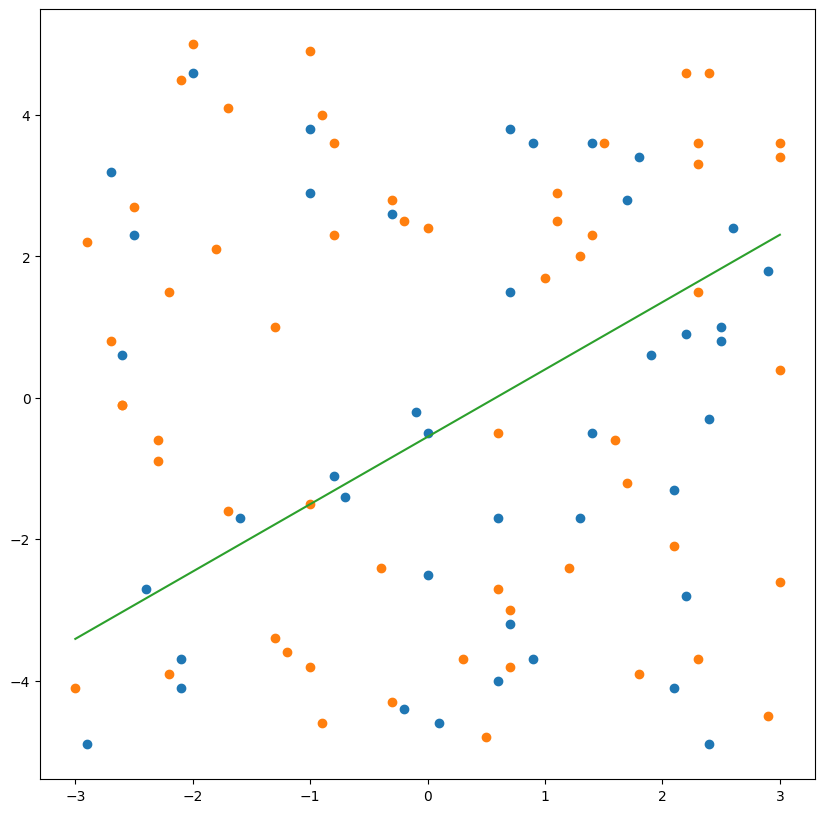

In [69]:
plot_hyperplane(X, Y, model)

In [70]:
df = pd.read_csv('./data1.csv')

X = df[['x', 'y']].to_numpy()
Y = df['label'].to_numpy()

model1 = Perceptron(eta=0.01, n_it_max=100)
model1.fit(X, Y)

Epoch 1: accuracy = 0.360
Epoch 2: accuracy = 0.920
Epoch 3: accuracy = 1.000


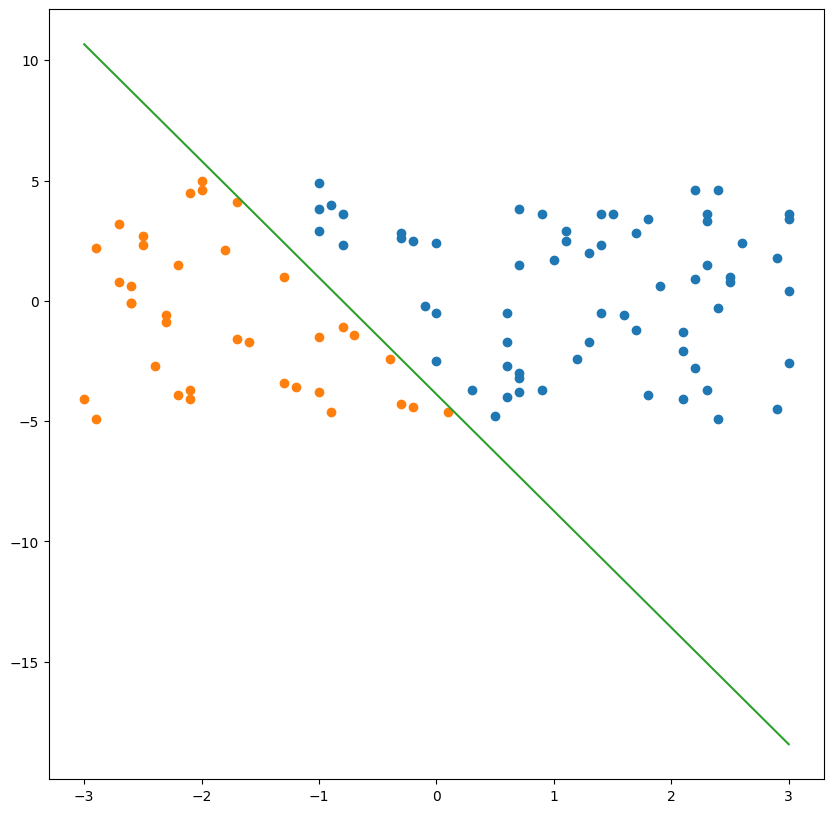

In [71]:
plot_hyperplane(X, Y, model1)

In [83]:
np.random.seed(18)
new_data = np.random.random(size = (10, 2))
new_data_labels = np.random.randint(2, size = 10)

labels = model1.predict(new_data)
accuracy = model1.check_classification(new_data_labels, labels)

print("Accuracy:", accuracy)

Accuracy: 0.6


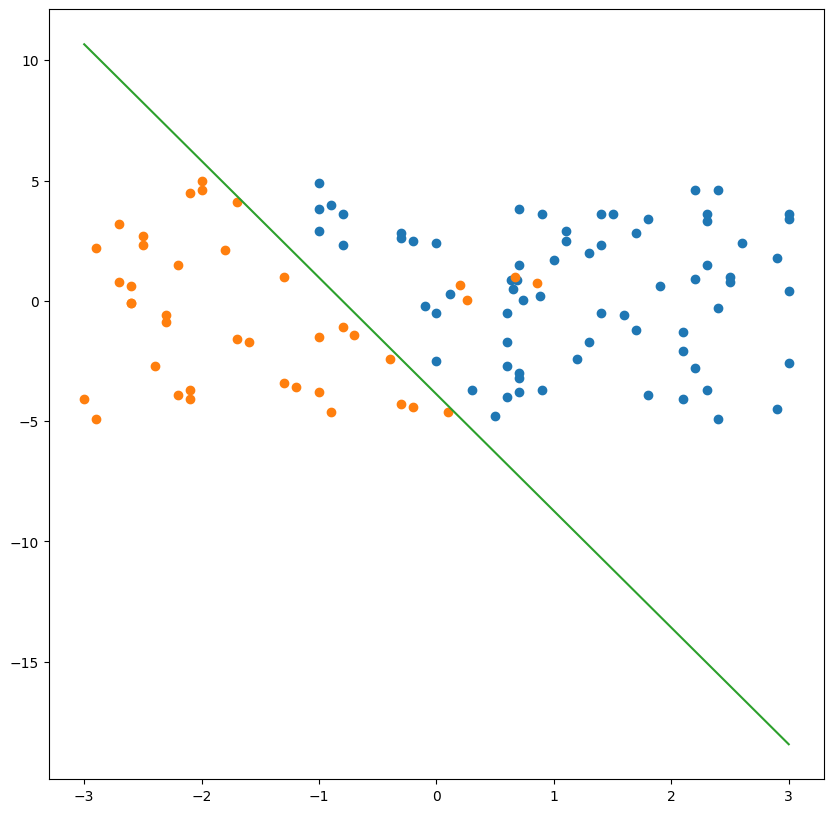

In [84]:
fake_X = np.concatenate((X, new_data))
fake_y = np.concatenate((Y, new_data_labels))

plot_hyperplane(fake_X, fake_y, model1)

5. Muestre que para A $\in R^m$,n con valores singulares σ_1, ..., σ_p, p = mın{m, n}, su norma esta dada por
$$
||A||_F = \sqrt(σ^2_1, + ..., + σ^2_p)

6. Considere nuevamente la base de datos de imágenes de dígitos de MNIST.
  - a) Calcule la descomposicion en valores singular de la matriz de asociada a los datos utilizando la funcion svd de la librería numpy.linalg.
 - b) Utilice la SVD para reducir la dimensión de los datos a la mitad, es decir realice un analisis de componentes principales.
 - c) Grafique 10 imágenes y sus respectivas proyeccciones una vez realizado en el analisis de componentes principales.
 - d) Para los datos proyectado calcule nuevamente su algoritmo de clustering y compare con los resultados obtenidos en la pregunta 2.